# Felix Unterleiter: <br/>"Convolutional Neural Networks for Denoising Low-Dose Computed Tomography Images": <br /> Implementation of the <a href="https://arxiv.org/pdf/1608.03981.pdf" target="_top">Dilated Residual Convolutional Neural Network</a>:

#### Dependencies:

In [ ]:
import torch
import torch.nn as nn
import h5py
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import random
import io
import math
import gc
from prettytable import PrettyTable
# from skimage.transform import iradon, radon

#### Specify Hyperparameters:

In [2]:
batch_size = 64
n_epochs = 40
learning_rate_SGD = 0.05
learning_rate_ADAM = 0.001
swtich_perc = 0.25

#### Data Preparation:

In [ ]:
samples_dir = os.fsencode(r"data/observation")
labels_dir = os.fsencode(r"data/ground_truth")
sino_list = []
samples_list = []
labels_list = []
total_samples = 3553  # total number of samples in the test part
num_valid_samples_last_file = total_samples % 128  # number of valid samples in the last file

for f in tqdm(sorted(os.listdir(samples_dir)), desc='Extracting the Sinogram Samples...'): # iterates over all h5 files in "observation"-directory
    f_path = os.path.join(samples_dir, f)
    h5_file = h5py.File(f_path.decode('utf-8'), 'r')
    n_samples = h5_file['data'].shape[0]

    # If this is the last file, only load the valid samples
    if f == sorted(os.listdir(samples_dir))[-1]:
        n_samples = num_valid_samples_last_file

    for i in range(n_samples):
        sino_list.append(np.array(h5_file['data'][i]))
    h5_file.close()

theta = np.linspace(0., 180., sino_list[0].shape[0], endpoint=False)

for sino in  tqdm(sino_list, desc='Transforming sinograms into images...'):
    # Convert the sinogram back to an image
    sample_image = iradon(sino.T, theta=theta, circle=True)

    # Rescale to get rid of black borders:
    x1, x2 = 75, -75
    y1, y2 = 75, -75
    sample_image = sample_image[y1:y2, x1:x2]

    # Crop so the dimensions math the ground truth
    sample_image = sample_image[:362, :362]
    samples_list.append(sample_image)

for f in tqdm(sorted(os.listdir(labels_dir)), desc='Extracting Labels...'):  # iterates over all h5 files in "ground_truth"-directory
    f_path = os.path.join(labels_dir, f)
    h5_file = h5py.File(f_path.decode('utf-8'), 'r')
    n_samples = h5_file['data'].shape[0]

    # If this is the last file, only load the valid samples
    if f == sorted(os.listdir(labels_dir))[-1]:
        n_samples = num_valid_samples_last_file

    for i in range(n_samples):
        labels_list.append(np.rot90(np.array(h5_file['data'][i]), 1))
    h5_file.close()

print(f'Number of samples: {len(samples_list)}')
print(type(samples_list[0]))

# Transform to tensor format:
samples_tens = torch.stack([torch.from_numpy(obs.copy()) for obs in samples_list])
labels_tens = torch.stack([torch.from_numpy(obs.copy()) for obs in labels_list])

# Save tensors to disk:
torch.save(samples_tens, r'data/samples_tens.pt')
torch.save(labels_tens, r'data/labels_tens.pt')

#### Create dataloaders:

In [ ]:
samples_tens = torch.load('data/samples_tens.pt')
labels_tens = torch.load("data/labels_tens.pt")

print(samples_tens.dtype, labels_tens.dtype)

# Split into training and validation:
test_size = 0.2
random_state = 69

obs_train, obs_test, labels_train, labels_test = train_test_split(
    samples_tens, labels_tens, test_size=test_size, random_state=random_state
)

# Create Datasets with tensors:
train_dataset = TensorDataset(obs_train, labels_train)
test_dataset = TensorDataset(obs_test, labels_test)
# test_dataset = train_dataset

# Create DataLoaders:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Visualize dataset:

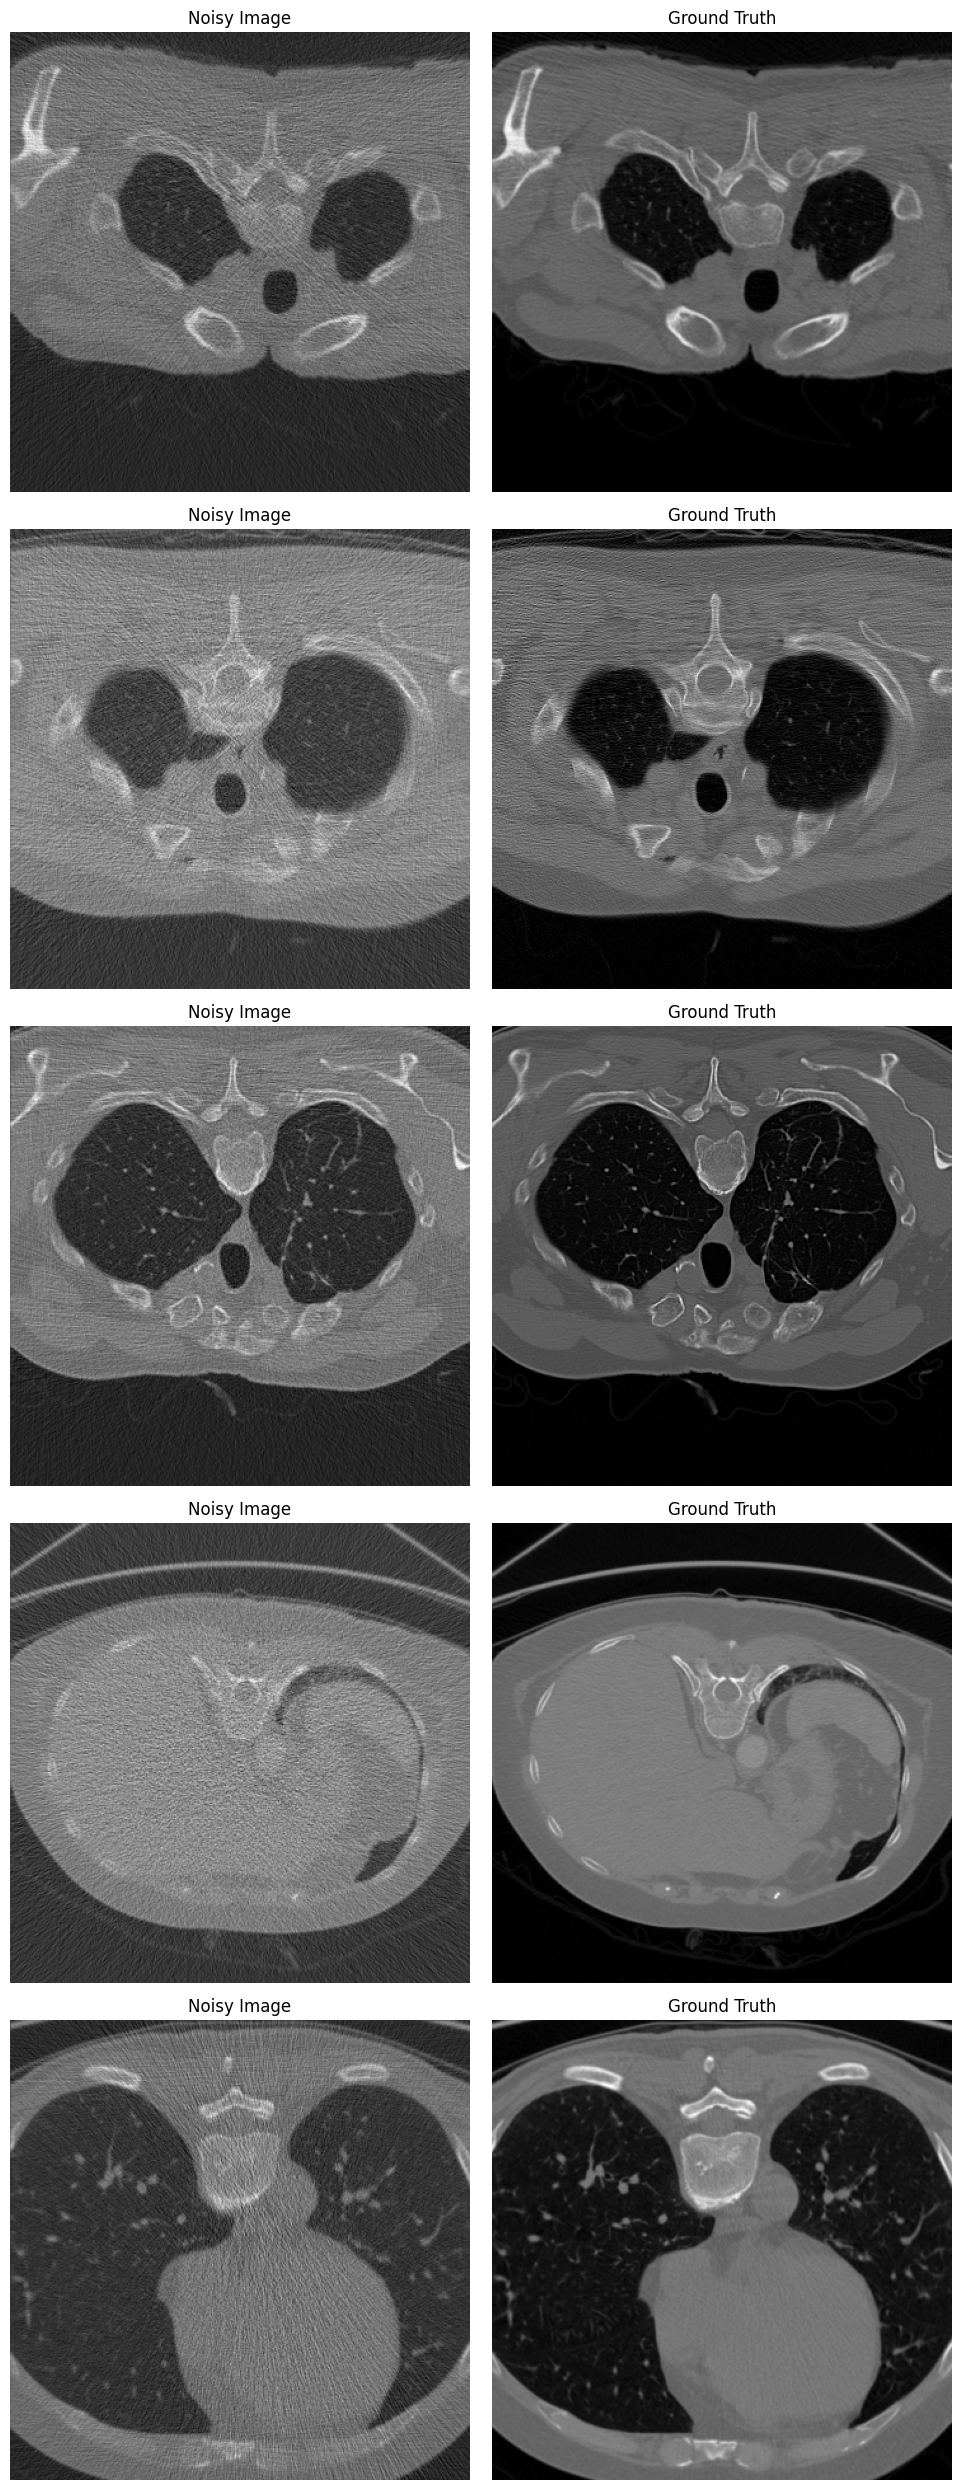

In [7]:
pics_i = [random.randint(0, 2553) for i in range(5)]

# Create a new figure
fig, axs = plt.subplots(5, 2, figsize=(10, 25))

for i, index in  enumerate(pics_i):
    sample = obs_train[index]
    label = labels_train[index]

    # Plot the sample and label
    axs[i, 0].imshow(sample, cmap='gray')
    axs[i, 0].set_title('Noisy Image')
    axs[i, 0].axis('off')

    # Plot the rotated label
    axs[i, 1].imshow(label, cmap='gray')
    axs[i, 1].set_title('Ground Truth')
    axs[i, 1].axis('off')

# Show the figure
plt.tight_layout()
plt.show()

#### Network Implementation:

In [13]:
class DilationCNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DilationCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=1),
            nn.ReLU()
        )

        self.dil_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.dil_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=3, dilation=3),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dil_conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, padding=4, dilation=4),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dil_conv4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=10, dilation=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.dil_conv5 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, padding=6, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )


        self.conv2 = nn.Sequential(
            nn.Conv2d(96, out_channels, kernel_size=5, padding=3),
            nn.ReLU()
        )

    def forward(self, x):
        resid_1 = x
        # print(f'Input tensor shape: {x.shape} (1)')

        x = self.conv1(x)
        # print(f'After conv1: {x.shape} (32)')
        resid_2 = x

        x = self.dil_conv1(x)
        # print(f'After dil_conv1: {x.shape} (64)')
        resid_3 = x

        x = self.dil_conv2(x)
        # print(f'After dil_conv2: {x.shape} (128)')
        x = self.dil_conv3(x)
        # print(f'After dil_conv3: {x.shape} (128)')
        x = self.dil_conv4(x)
        # print(f'After dil_conv4: {x.shape} (64)')

        # print(f'Shape of resid3: {resid_3.shape}')
        x = torch.cat((x, resid_3), dim=1)
        # print(f'After first concat: {x.shape}')
        x = self.dil_conv5(x)
        # print(f'After dil_conv5: {x.shape} (64)')
        # print(f'Shape of resid2: {resid_2.shape}')

        x = torch.cat((x, resid_2), dim=1)
        # print(f'After second concat: {x.shape}')
        x = self.conv2(x)
        # print(f'After conv2: {x.shape} (32)')
        # print(f'Shape of resid1: {resid_1.shape}')
        x = x + resid_1

        return x

In [16]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

ModuleNotFoundError: No module named 'prettytable'

#### Training loop:

In [5]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.plot(ave_grads, alpha=0.3, color="r")
    # plt.hlines(0, 0, len(ave_grads)+1, linewidth=3, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

# clear gpu cache:
gc.collect()
torch.cuda.empty_cache()

model = DilationCNN(in_channels=1, out_channels=1).to(device)

for m in model.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

criterion = nn.MSELoss()
optim_ADAM = torch.optim.Adam(model.parameters())
optim_SGD = torch.optim.SGD(model.parameters(), lr=learning_rate_SGD)
# scheduler = torch.optim.lr_scheduler.StepLR(optim_ADAM, step_size=2, gamma=0.2)

n_adam_eps = math.floor(n_epochs * swtich_perc)
torch.autograd.set_detect_anomaly(True)
loss_hist = []
psnr_hist = []

for epoch in range(n_epochs):
    model.train()
    if epoch <= n_adam_eps:
        optimizer = optim_ADAM
    else:
        optimizer = optim_SGD

    for batch_idx, (samples, labels) in enumerate(tqdm(train_dataloader, desc="Going over batches...")):
        # Move the data to the device
        samples = samples.unsqueeze(1).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(samples)
        loss = criterion(outputs, labels.unsqueeze(1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Plot gradient flow
        # plot_grad_flow(model.named_parameters())

        optimizer.step()

    print(f"Epoch [{epoch+1}/{n_epochs}]")

    # Evaluation on the test dataset
    model.eval()  # Set the model to evaluation mode
    total_psnr = 0.0
    total_mse = 0.0

    with torch.no_grad():
        for samples, labels in test_dataloader:
            # Move the data to the device
            samples = samples.unsqueeze(1).to(device)
            labels = labels.unsqueeze(1).to(device)

            # Forward pass
            outputs = model(samples)

            # Calculate PSNR
            mse = criterion(outputs, labels)
            psnr = 10 * torch.log10(1 / mse)
            total_psnr += psnr.item()
            total_mse += mse.item()

    average_psnr = total_psnr / len(test_dataloader)
    average_loss = total_mse / len(test_dataloader)

    print(f"---|Epoch [{epoch+1}/{n_epochs}], Average PSNR: {average_psnr:.8f}, Average Loss: {average_loss:.8f}")
    psnr_hist.append(average_psnr)

    torch.save(model.state_dict(), f'models/V1/{epoch+1}_{average_psnr:.4f}_{average_loss:.4f}.pt')

Device: cuda


Going over batches...:   1%|          | 2/178 [01:11<1:45:30, 35.97s/it]


KeyboardInterrupt: 

In [ ]:
print(loss_hist, psnr_hist)